## This Notebook is a basic tutorial to run KinPFN on a single RNA molecule (with a length of 86 nucleotides; [Data](./tutorial_sequence_86nt_1000_folding_simulations.csv)) for which we have a certain number of first passage times from folding simulations. The goal is to approximate the ground truth cumulative distribution function (CDF) of these times.

In [6]:
import os
import torch
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

from kinpfn.priors import Batch
from kinpfn.model import KINPFN

In [7]:
# Load trained model
model_path = "../models/final_kinpfn_model_1400_1000_1000_86_50_2.5588748050825984e-05_256_4_512_8_0.0_0.0.pt"

kinpfn = KINPFN(
    model_path=model_path,
)
trained_model = kinpfn.model

if trained_model is not None:
    print("Load trained model!")
else:
    print("No trained model found!")
    exit()

Model loaded from path ../models/final_kinpfn_model_1400_1000_1000_86_50_2.5588748050825984e-05_256_4_512_8_0.0_0.0.pt.
Load trained model!


In [8]:
def get_dataset_size(csv_dir):
    dataset_size = 0
    for subdir, _, files in os.walk(csv_dir):
        for file in files:
            if file.endswith(".csv"):
                dataset_size += 1
    return dataset_size

# Read out ground truth first passage times from csv files (these can be generated using a kinetic simulator like Kinfold)
def get_batch_available_first_passage_times(csv_file, seq_len=100, num_features=1, **kwargs):
    """
    This function reads the first passage times from a csv file in the given directory and returns a batch of data readable by KinPFN.

    Args:
    csv_dir: str
        The directory where the csv files are stored.
    seq_len: int
        The sequence length of the data, meaning the total number of first passage times that are read out of the csv file.
    num_features: int
        The number of features in the data which is always 1 in the case of KinPFN.
    """


    dataset_size = 1

    x = torch.zeros(seq_len, dataset_size, num_features)
    y = torch.zeros(seq_len, dataset_size)

    batch_index = 0
    data = pl.read_csv(
        csv_file,
        has_header=False,
        columns=[2, 4],
        n_rows=seq_len,
    )

    folding_times = data["column_3"].to_numpy()
    sequence = data["column_5"][0]
    sorted_folding_times = np.sort(folding_times)

    # Filter out points where x > 10^15 and x < 10^-6
    valid_indices = (sorted_folding_times <= 10**15) & (
        sorted_folding_times >= 10**-6
    )
    sorted_folding_times = sorted_folding_times[valid_indices]

    # Adjust the sequence length by sampling, if the first passage times exceed the bounds
    current_seq_len = len(sorted_folding_times)
    if current_seq_len <= 0:
        return None, sequence

    if current_seq_len < seq_len:
        # Repeat the sorted_folding_times and cdf to match the sequence length (Oversampling) (Only if bounds are exceeded)
        repeat_factor = seq_len // current_seq_len + 1
        sorted_folding_times = np.tile(sorted_folding_times, repeat_factor)[
            :seq_len
        ]
    else:
        sorted_folding_times = sorted_folding_times[:seq_len]

    x[:, batch_index, 0] = torch.tensor(np.zeros(seq_len))
    y[:, batch_index] = torch.tensor(sorted_folding_times)

    y = torch.log10(y)
    return Batch(x=x, y=y, target_y=y), sequence

In [9]:
def run_kinpfn_tutorial(trained_model):
    """
    This function runs the trained KinPFN model on a single example approximates the first passage time distribution, calculates the CDF and plots the results.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seq_len = 1000
    training_points = [10, 25, 50, 75]

    num_evaluations = 1

    csv_file = "./tutorial_sequence_86nt_1000_folding_simulations.csv"

    batch, rna_sequence = get_batch_available_first_passage_times(
        csv_file=csv_file, seq_len=seq_len
    )

    x = batch.x
    y_folding_times = batch.y
    target_y_folding_times = batch.target_y

    mae_losses = []
    mean_nll_losses = []

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(training_points),
        figsize=(24, 6),
        layout="constrained",
    )
    fig.set_dpi(300)

    for i in range(num_evaluations):

        batch_index = i

        axes[0].set_title(
            f"RNA Sequence Length {len(rna_sequence)}", fontsize=15
        )

        for j, training_point in enumerate(training_points):
            print(f"Approximating with {training_point} context first passage times")
            col = j
            ax = axes[col]
            train_indices = torch.randperm(seq_len)[:training_point]

            # Create the training and test data
            train_x = x[train_indices, batch_index]
            train_y_folding_times = y_folding_times[train_indices, batch_index]

            test_x = x[:, batch_index]
            test_y_folding_times = y_folding_times[:, batch_index]

            train_x = train_x.to(device)
            train_y_folding_times = train_y_folding_times.to(device)
            test_x = test_x.to(device)
            test_y_folding_times = test_y_folding_times.to(device)

            # Run the trained model on the context first passage times for a single forward pass
            with torch.no_grad():
                logits = trained_model(
                    train_x[:, None], train_y_folding_times[:, None], test_x[:, None]
                )

            ground_truth_sorted_folding_times, _ = torch.sort(test_y_folding_times)
            ground_truth_cdf = torch.arange(
                1, len(ground_truth_sorted_folding_times) + 1
            ) / len(ground_truth_sorted_folding_times)

            test_y_folding_times_sorted, _ = torch.sort(test_y_folding_times)
            train_y_folding_times_sorted, _ = torch.sort(train_y_folding_times)

            pred_cdf_original = (
                trained_model.criterion.cdf(logits, test_y_folding_times_sorted)
            )[0][0]

            linspace_extended = torch.linspace(
                train_y_folding_times_sorted[0] - 1,
                train_y_folding_times_sorted[-1] + 1,
                1000,
            )

            # Approximate the CDF for a specific linear space, 
            # in this case a linspace that is extended by 1 on both sides of the available context first passage times
            # This can be set to any linspace that is of interest inside the bounds of 10^-6 and 10^15
            pred_cdf_linspace_extended = (
                trained_model.criterion.cdf(logits, linspace_extended)
            )[0][0]

            ax.scatter(
                10**ground_truth_sorted_folding_times,
                ground_truth_cdf,
                color="#000000",
                marker="x",
                label="Target F(t)",
            )
            ax.scatter(
                10**linspace_extended,
                pred_cdf_linspace_extended,
                color="#cc101fc7",
                marker=".",
                label="KinPFN F(t)",
            )
            ax.scatter(
                10**train_y_folding_times_sorted,
                torch.zeros_like(train_y_folding_times_sorted),
                color="blue",
                marker="o",
                label="Context First Passage Times",
            )

            ax.set_ylim(0, 1)
            ax.set_xscale("log")
            ax.set_xlabel("Time t", fontsize=15)
            if col == 0:
                ax.set_ylabel("Cumulative Population Probability F(t)", fontsize=15)


            ## METRICS
            # Prior-Data Negative Log Likelihood between the approximated posterior predictive distribution (PPD) and the ground truth PPD
            nll_loss = trained_model.criterion.forward(
                logits=logits, y=test_y_folding_times_sorted
            )
            mean_nll_loss = nll_loss.mean()
            mean_nll_losses.append(mean_nll_loss)
            # Mean Absolute Error between the approximated CDF and the ground truth CDF
            single_absolute_error = np.abs(pred_cdf_original - ground_truth_cdf)
            mae = single_absolute_error.mean()
            mae_losses.append(mae)

            ax.legend(fontsize=14)

    plt.tight_layout()
    plt.show()

Approximating with 10 context first passage times
Approximating with 25 context first passage times
Approximating with 50 context first passage times
Approximating with 75 context first passage times


/tmp/ipykernel_28413/2091972797.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


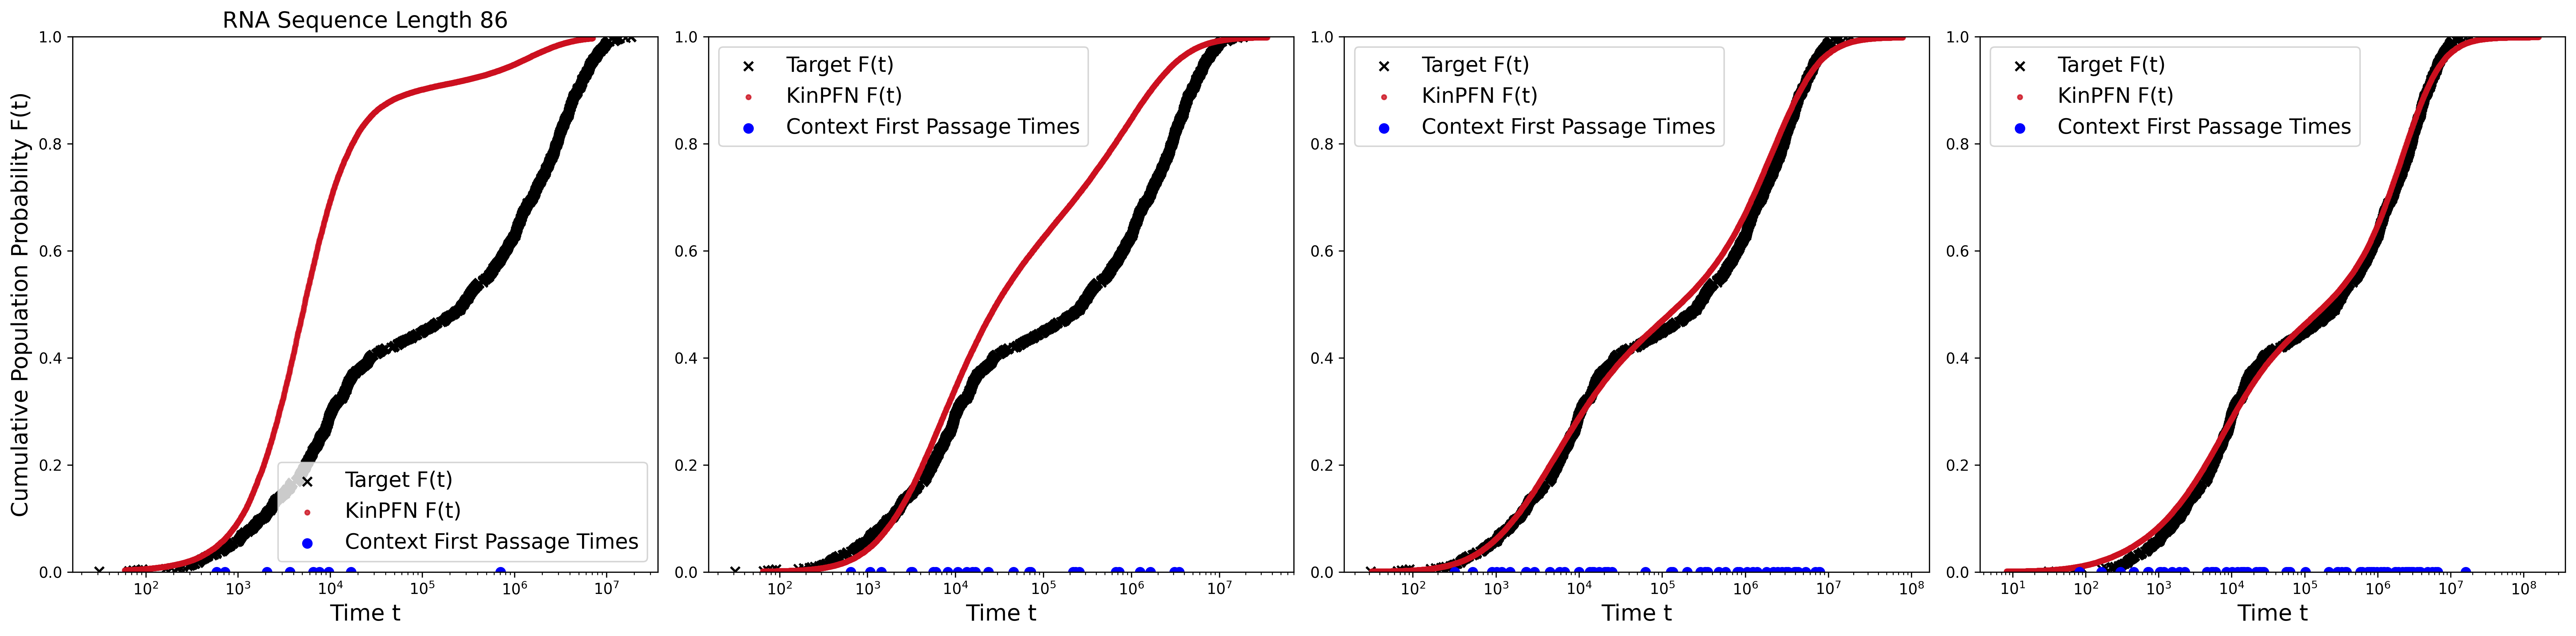

In [10]:
run_kinpfn_tutorial(trained_model)